# Simulate circles for multi-segment array

# Import libraries

In [91]:
import os
import math
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.sparse import save_npz, load_npz

from scipy.ndimage import affine_transform as affine
from scipy.ndimage import gaussian_filter

# custom libraries
if '../utils' not in sys.path:
    sys.path.append('../utils')

from modelMatrix import calculateModelMatrix
from regularization import calculateRegularizationMatrix
from normalize import sigMatNormalize
from filterBandPass import sigMatFilter
from cpuMB import sigMatReconMB
from crop import cropMatrix

# Main

In [92]:
#===== recon parameters =====#

speedOfSound    = 1525
resolutionXY    = 256
reconDimsXY     = 0.0256                      # recon dimensions x and y [m]
fSampling       = 40e6
delayInSamples  = 61                                 # DAQ delay
nSamples        = 2030;                              # number of samples
timePoints      = np.arange(0, (nSamples)/fSampling, 1/fSampling) + delayInSamples/fSampling
nAngles         = 2*resolutionXY
lambdaReg       = 15e6
iterationNum    = 10
lowCutOff       = 0.1e6
highCutOff      = 6e6
fOrder          = 3


# timePoints      = cropMatrix(timePoints, xSensor, ySensor, reconDimsXY, fSampling, speedOfSound, delayInSamples, nSamples)



# Simulate Ellipse and Skin Line

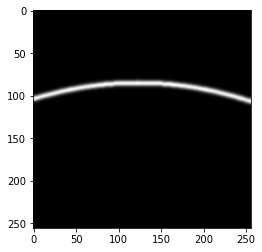

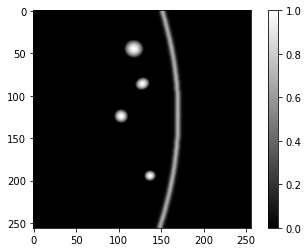

centerEllipseX:  45 , centerEllipseY:  137


In [93]:
#===== simulation parameters =====#
numImages       = 1
numEllipses     = 4

rVerticalMax    = 20
rHorizontalMin  = 5
rHorizontalMax  = 30

# range of eccentricty of the ellipse
hor2ver_ratio_min = 0.6
hor2ver_ratio_max = 1.

# width of the skin line
lineWidth       = 2
parabolaWidth   = 800

# create mesh to use in line and ellipse
x               = np.linspace(0,resolutionXY-1,resolutionXY)
y               = np.linspace(0,resolutionXY-1,resolutionXY)
meshX, meshY    = np.meshgrid(x,y)

# loop through the images that you want to create 
for indImage in range(0,numImages):

    # create an empty image
    imageEllipses   = np.zeros((resolutionXY, resolutionXY))

    # create the skin line first
    imageLine       = np.zeros((resolutionXY, resolutionXY))
    
    centerLineX     = np.random.randint(0, resolutionXY) # doesnt effect that much beacuse we create a big curve
    centerLineY     = np.random.randint(30, 110) # we do not want skin line to touch the top or bottom
    
    posLineX        = (meshX - centerLineX)
    posLineY        = (meshY - centerLineY)
    
    # create a wide parabola
    imageLine       = 1 - ((posLineX)**2/parabolaWidth - (posLineY))
    
    #crop parabola to get line
    indCrop = np.where(np.logical_and(imageLine >= -lineWidth, imageLine <= lineWidth))
    
    # make everyhing zero except line
    lineCropped = imageLine*0

    # make line 1
    lineCropped[indCrop[0], indCrop[1]] = 1

    # apply gaussian to smooth
    lineCropped = np.clip(gaussian_filter(lineCropped, sigma=2), 0, 1)
    
    # visualize
    plt.figure()
    plt.imshow(lineCropped, cmap='gray')
    plt.show

    # add line to empty image first so it can check violation as well
    imageEllipses   += lineCropped

    # plotThresholdHorizontal = np.amin(indCrop[0]) # there will be this many pixels from image border along rows (X)
    
    maxDepthThresholdHorizontal = np.amax(indCrop[0]) # there cannot be ellipses far too deep (not enough penetration) (X)

    for indEllipse in range(0,numEllipses):

        is_violating = True

        while is_violating: # Rough check to make sure no objects overlap.

            # define random ellipse parameters
            rVertical = np.random.uniform(rHorizontalMin, rHorizontalMax)
            rHorizontal = np.random.uniform(hor2ver_ratio_min, hor2ver_ratio_max) * rVertical

            rotationAngle       = np.random.normal(loc=1, scale=math.pi/8 / 3)  * math.pi # make sure most are horizontal. (have 3std as pi/8)

            centerEllipseX      = np.random.randint(resolutionXY)
            centerEllipseY      = np.random.randint(maxDepthThresholdHorizontal, min(maxDepthThresholdHorizontal+50, resolutionXY))
            

            # Draw ellipse 
            cos = np.cos(rotationAngle)
            sin = np.sin(rotationAngle)

            meshX_ = meshX - centerEllipseX
            meshY_ = meshY - centerEllipseY

            singleImage = 1 - (((meshX_ * cos + meshY_ * sin) ** 2 ) / (rHorizontal**2) + ((meshX_ * sin - meshY_ * cos)**2) / (rVertical**2))

            singleImage[singleImage < 0] = 0

            is_violating = np.sum(np.logical_and(imageEllipses.flatten()!=0., singleImage.flatten()!=0.)) > 0.

            

        imageEllipses       += singleImage

imageClipped    = np.clip(imageEllipses, 0, 1)

imageClipped    = np.rot90(imageClipped, 3)

#===== visualize image =====#

plt.figure()
plt.imshow(imageClipped, cmap='gray')
plt.colorbar()
plt.show()

print('centerEllipseX: ', centerEllipseX, ', centerEllipseY: ', centerEllipseY)

imageFlat       = imageClipped.reshape(-1)

# Virtual Ring Array

In [94]:
#===== load transducer positions =====#
array_dir           = '../utils/arrayInfo/virtualRingCup.mat'
arrayFile	        = sio.loadmat(array_dir)
transducerPos	    = arrayFile['transducerPos']

xSensorVirtualRing = np.transpose(transducerPos[:,0])   # positions in x
ySensorVirtualRing = np.transpose(transducerPos[:,1])   # positions in y
rSensorVirtualRing = np.sqrt(xSensorVirtualRing**2 + ySensorVirtualRing**2)

theta           = np.arctan2(ySensorVirtualRing,xSensorVirtualRing)
angleSensor     = theta + 2*math.pi*(np.multiply((xSensorVirtualRing>0),(ySensorVirtualRing<0)))

In [95]:
modelMatrixVirtualRing     = calculateModelMatrix(speedOfSound, resolutionXY, reconDimsXY, timePoints, rSensorVirtualRing, angleSensor, nAngles)

# save_npz('../data/modelMatrixVirtualRing.npz', modelMatrixVirtualRing)

In [96]:
# modelMatrixVirtualRing = load_npz('../data/modelMatrixVirtualRing.npz')

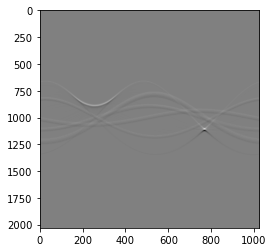

In [97]:
#===== forward model =====#
sigMatVec           = modelMatrixVirtualRing*imageFlat

sigMatVirtualRing   = np.transpose(sigMatVec.reshape(len(xSensorVirtualRing), -1))

#===== visualize signals =====#
plt.figure()
plt.imshow(sigMatVirtualRing, cmap='gray')
plt.show
plt.axes().set_aspect(0.5)



In [103]:
# expand dimensions
if sigMatVirtualRing.ndim != 3:
    sigMatVirtualRing = np.expand_dims(sigMatVirtualRing, axis=2)

# filter sigMat
sigMatVirtualRingF = sigMatFilter(sigMatVirtualRing, lowCutOff, highCutOff, fSampling, fOrder, 0.5)

# normalize sigMat around 0
sigMatVirtualRingN         = sigMatNormalize(sigMatVirtualRingF)

# MB

<function matplotlib.pyplot.show(*args, **kw)>

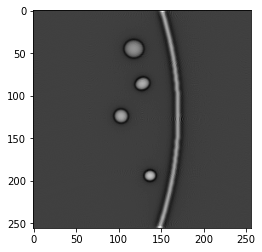

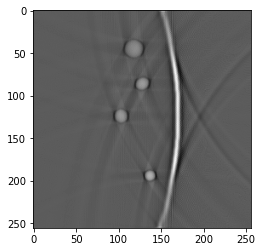

In [104]:
#===== reconstruct image =====#
regMatrix       = calculateRegularizationMatrix(resolutionXY, lambdaReg)

# crop sigMat
# sigMat          = cropMatrix(sigMat, xSensor, ySensor, reconDimsXY, fSampling, speedOfSound, delayInSamples, nSamples)

# reconstruction
imageReconVirtualRing = sigMatReconMB(sigMatVirtualRingN, modelMatrixVirtualRing, regMatrix, iterationNum, resolutionXY)

#===== visualize image =====#
plt.figure()
plt.imshow(imageReconVirtualRing, cmap='gray')
plt.show
